In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import ndimage as ndi

import pylandstats as pls

sns.set()

In [8]:
URBAN_CLASS_VAL = 1
NONURBAN_CLASS_VAL = 2

year_codes = ['00', '06', '12', '18']
city_slugs = ['basel', 'bern', 'geneve', 'lausanne', 'zurich']
class_metrics = [
    'area_mn', 'proportion_of_landscape', 'largest_patch_index',
    'edge_density', 'fractal_dimension_am',
    'euclidean_nearest_neighbor_mn', 'landscape_shape_index',
    'number_of_patches', 'patch_density'
]
landscape_metrics = ['contagion', 'shannon_diversity_index']

In [4]:
city_sta_dict = {
    city_slug : pls.SpatioTemporalAnalysis(
        ['../data/processed/agglomeration_extracts/'
        f'{city_slug}/{year_code}/{year_code}.tif'
         for year_code in year_codes],
        metrics=class_metrics+landscape_metrics, classes=[1],
        dates=year_codes
    )
    for city_slug in city_slugs
}

In [5]:
KERNEL_MOORE = ndi.generate_binary_structure(2, 2)

def new_patches_label(
        landscape_base_arr, landscape_prime_arr, urban_class_val):
    new_patches_arr = (landscape_prime_arr == urban_class_val) & \
                      (landscape_base_arr != urban_class_val)
    return ndi.label(new_patches_arr, KERNEL_MOORE)

def compute_patch_areas(label_arr):        
    return np.bincount(label_arr.ravel())[1:]
    
def compute_patch_leis(label_arr, num_patches, landscape_prime_arr,
                       urban_class_val, nonurban_class_val):
    patch_leis = []
    for k in range(1, num_patches + 1):
        patch_arr = label_arr == k
        buffer_zone_arr = ndi.binary_dilation(
            patch_arr, KERNEL_MOORE) & ~patch_arr
        buffer_class_values = landscape_prime_arr[buffer_zone_arr]
        area_urban = np.sum(buffer_class_values == urban_class_val)
        area_nonurban = np.sum(buffer_class_values == nonurban_class_val)
        patch_leis.append(area_urban / (area_urban + area_nonurban))

    return patch_leis

In [12]:
def area_weighted_count(patch_areas, cond):
    return np.sum(patch_areas[cond]) / np.sum(patch_areas)

def plot_growth_modes(sta, urban_class_val, nonurban_class_val,
                      weight='number', ax=None, subplots_kws={}):
    if ax is None:
        fig, ax = plt.subplots(**subplots_kws)

    t_range = range(len(sta) - 1)
    # grouped bar plot idea from Chris Albon https://bit.ly/2JrybQ5
    pos = list(t_range)
    width = .25

    leapfrogs = np.zeros(len(t_range))
    edge_expansions = np.zeros(len(t_range))
    infills = np.zeros(len(t_range))
    for t in t_range:
        landscape_base_arr = sta.landscapes[t].landscape_arr
        landscape_prime_arr = sta.landscapes[t + 1].landscape_arr
        label_arr, num_patches = new_patches_label(
            landscape_base_arr, landscape_prime_arr, urban_class_val)
        patch_leis = np.array(
            compute_patch_leis(label_arr, num_patches, landscape_prime_arr,
                               urban_class_val, nonurban_class_val))

        leapfrog_cond = np.isclose(patch_leis, 0)
        edge_expansion_cond = (patch_leis > 0) & (patch_leis <= .5)
        infill_cond = patch_leis > .5
        
        if weight == 'number':
            leapfrog = np.sum(leapfrog_cond) / num_patches
            edge_expansion = np.sum(edge_expansion_cond) / num_patches
            infill = np.sum(infill_cond) / num_patches
        else:  # 'area'
            patch_areas = compute_patch_areas(label_arr)
            leapfrog = area_weighted_count(patch_areas, leapfrog_cond)
            edge_expansion = area_weighted_count(
                patch_areas, edge_expansion_cond)
            infill = area_weighted_count(patch_areas, infill_cond)

        leapfrogs[t] = leapfrog
        edge_expansions[t] = edge_expansion
        infills[t] = infill

    ax.bar(pos, leapfrogs * 100, width, label='leapfrog')
    ax.bar([p + width for p in pos], edge_expansions * 100, width,
           label='edge-expansion')
    ax.bar([p + 2 * width for p in pos], infills * 100, width, label='infill')

    if weight == 'number':
        ax.set_ylabel('% patch number')
    else:  # 'area'
        ax.set_ylabel('% area')
    ax.set_xticks([p + width for p in pos])
    ax.set_xticklabels(
        ['{}-{}'.format(sta.dates[t], sta.dates[t+1]) for t in t_range])
    ax.legend()
    
    return ax

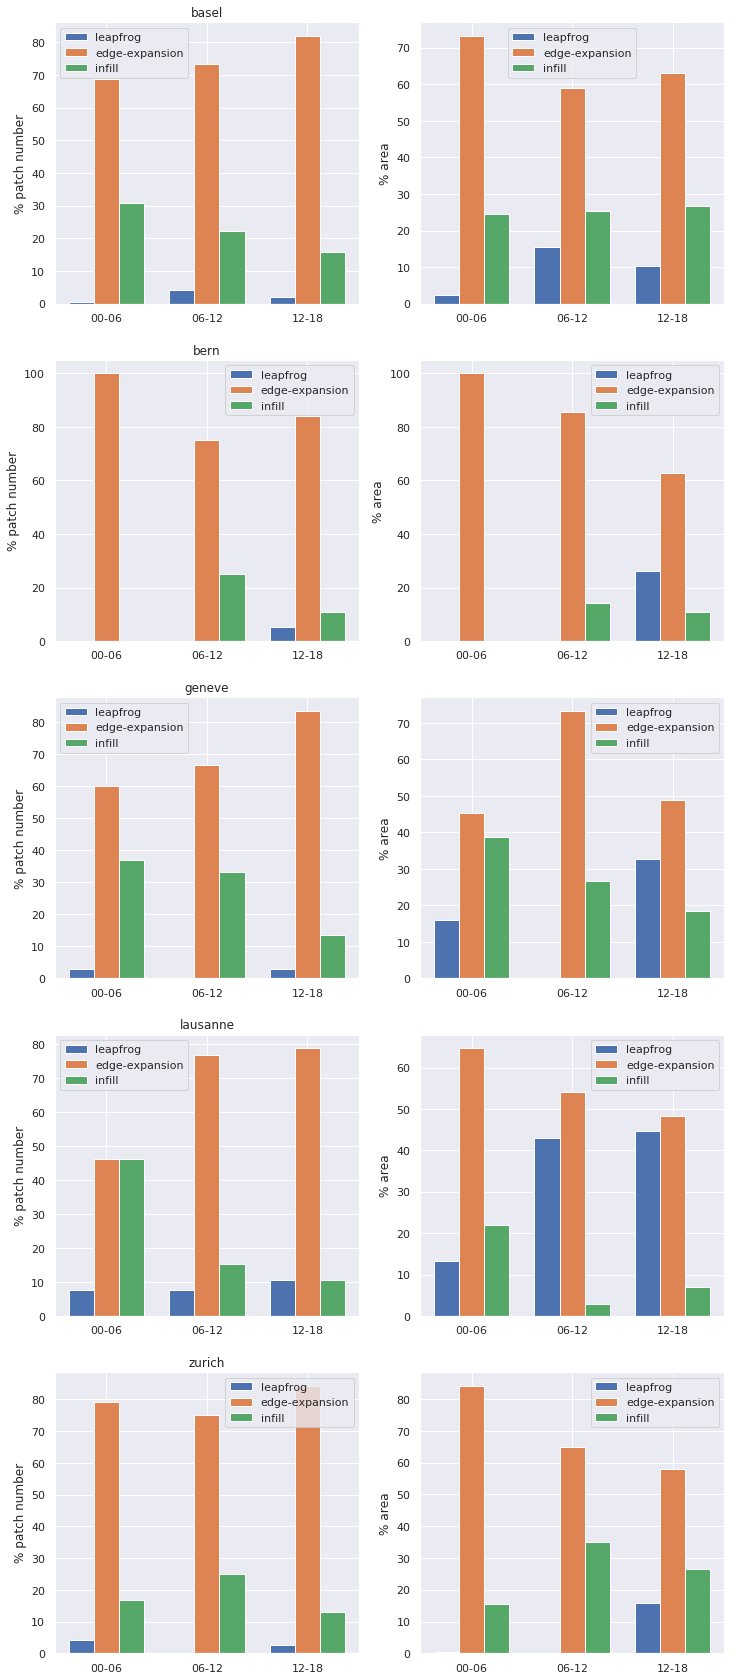

In [13]:
num_cities = len(city_sta_dict)
fig, axes = plt.subplots(num_cities, 2, figsize=(2 * 6, num_cities * 6))

for city_slug, ax_row in zip(city_slugs, axes):
    city_sta = city_sta_dict[city_slug]
    ax = plot_growth_modes(city_sta, URBAN_CLASS_VAL, NONURBAN_CLASS_VAL,
                           weight='number', ax=ax_row[0])
    ax.set_title(city_slug)
    ax = plot_growth_modes(city_sta, URBAN_CLASS_VAL, NONURBAN_CLASS_VAL,
                           weight='area', ax=ax_row[1])